In [1]:
import hopsworks
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os

In [2]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/196758
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="wine", version=1)
query = wine_fg.select_all()
label_encoder = fs.get_transformation_function(name="label_encoder")
feature_view = fs.get_or_create_feature_view(
    name="wine",
    version=1,
    description="Read from wine quality dataset",
    labels=["quality"],
    query=query,
    transformation_functions={
        "type": label_encoder
    }
)

Issue: It seems like labels are NOT separated and "type" is NOT encoded.

In [4]:
# # You can read training data, randomly split into train/test sets of features (X) and labels (y)        
# X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

# # Train our model with the Scikit-learn K-nearest-neighbors algorithm using our features (X_train) and labels (y_train)
# model = KNeighborsClassifier(n_neighbors=2)
# model.fit(X_train, y_train)

In [5]:
train, test, _, _ = feature_view.train_test_split(0.2)

Finished: Reading data from Hopsworks, using ArrowFlight (1.16s) 


In [6]:
#split one column as targets
def feature_target_split(df, column_name):
    features = df.drop(column_name, axis=1).reset_index(drop=True)
    targets = df[column_name].reset_index(drop=True)
    return features, targets

# One-hot encode the categorical feature
def one_hot_encoder(df, column_name):
    from sklearn.preprocessing import OneHotEncoder
    encoder = OneHotEncoder(drop='first',sparse=False)
    encoded_features = encoder.fit_transform(df[[column_name]])
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out([column_name]))
    encoded_df = pd.concat([df.drop(column_name, axis=1), encoded_df], axis=1)
    return encoded_df

In [7]:
X_train, y_train = feature_target_split(train, 'quality')
X_test, y_test = feature_target_split(test, 'quality')
X_train

,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,density,ph,sulphates,alcohol
0,red,11.8,0.330,0.49,3.40,0.093,54.0,1.00020,3.30,0.76,10.70
1,red,8.6,0.685,0.10,1.60,0.092,3.0,0.99745,3.31,0.65,9.55
2,white,6.6,0.500,0.26,11.30,0.029,32.0,0.99302,3.27,0.78,12.90
3,red,7.7,0.600,0.00,2.60,0.055,7.0,0.99639,3.38,0.56,10.80
4,white,7.9,0.460,0.32,4.10,0.033,40.0,0.99120,3.18,0.44,12.80
...,...,...,...,...,...,...,...,...,...,...,...
4224,white,6.5,0.115,0.29,1.95,0.038,73.0,0.98900,3.12,0.25,12.90
4225,red,7.0,0.580,0.28,4.80,0.085,12.0,0.99633,3.32,0.70,11.00
4226,white,6.7,0.210,0.34,1.40,0.049,36.0,0.99091,3.02,0.50,11.00
4227,white,5.4,0.375,0.40,3.30,0.054,29.0,0.99482,3.42,0.52,9.10


In [8]:
X_train = one_hot_encoder(X_train, 'type')
X_test = one_hot_encoder(X_test, 'type')
X_train

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,density,ph,sulphates,alcohol,type_white
0,11.8,0.330,0.49,3.40,0.093,54.0,1.00020,3.30,0.76,10.70,0.0
1,8.6,0.685,0.10,1.60,0.092,3.0,0.99745,3.31,0.65,9.55,0.0
2,6.6,0.500,0.26,11.30,0.029,32.0,0.99302,3.27,0.78,12.90,1.0
3,7.7,0.600,0.00,2.60,0.055,7.0,0.99639,3.38,0.56,10.80,0.0
4,7.9,0.460,0.32,4.10,0.033,40.0,0.99120,3.18,0.44,12.80,1.0
...,...,...,...,...,...,...,...,...,...,...,...
4224,6.5,0.115,0.29,1.95,0.038,73.0,0.98900,3.12,0.25,12.90,1.0
4225,7.0,0.580,0.28,4.80,0.085,12.0,0.99633,3.32,0.70,11.00,0.0
4226,6.7,0.210,0.34,1.40,0.049,36.0,0.99091,3.02,0.50,11.00,1.0
4227,5.4,0.375,0.40,3.30,0.054,29.0,0.99482,3.42,0.52,9.10,1.0


In [14]:
# Train our model with the Scikit-learn K-nearest-neighbors algorithm using our features (X_train) and labels (y_train)
# Use Scikit-learn RandomizedSearchCV to fine-tune the hyperparameters in order to optimise the model

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameters grid
param_dist = {
    'n_neighbors': randint(1, 50),
    'p': [1, 2],
    'weights': ["uniform", "distance"],
}

# Create a KNN Classifier
knn = KNeighborsClassifier()

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(knn, param_distributions=param_dist, n_iter=50, cv=3)

# Fit the model to the training data
random_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best Hyperparameters::\n{}".format(random_search.best_params_))
print("\nHighest Cross Validation Score::{}".format(random_search.best_score_))

# Evaluate model performance using the features from the test set (X_test)
model = random_search.best_estimator_
y_pred = model.predict(X_test)

# Calculate the accuracy of the best model
print("\nTesting Accuracy::{}".format(accuracy_score(y_test, y_pred)))

Best Hyperparameters::
{'n_neighbors': 37, 'p': 1, 'weights': 'distance'}

Highest Cross Validation Score::0.5062628459061723

Testing Accuracy::0.5434782608695652


In [16]:
# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True, zero_division = 0)
results = confusion_matrix(y_test, y_pred)

In [17]:
print(metrics)

{'3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3}, '4': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 46}, '5': {'precision': 0.5876623376623377, 'recall': 0.5435435435435435, 'f1-score': 0.5647425897035881, 'support': 333}, '6': {'precision': 0.5238095238095238, 'recall': 0.7410526315789474, 'f1-score': 0.6137750653879686, 'support': 475}, '7': {'precision': 0.5384615384615384, 'recall': 0.24561403508771928, 'f1-score': 0.3373493975903615, 'support': 171}, '8': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 29}, '9': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1}, 'accuracy': 0.5434782608695652, 'macro avg': {'precision': 0.23570477141905716, 'recall': 0.21860145860145858, 'f1-score': 0.2165524360974169, 'support': 1058}, 'weighted avg': {'precision': 0.5071625759243907, 'recall': 0.5434782608695652, 'f1-score': 0.5078347688265895, 'support': 1058}}


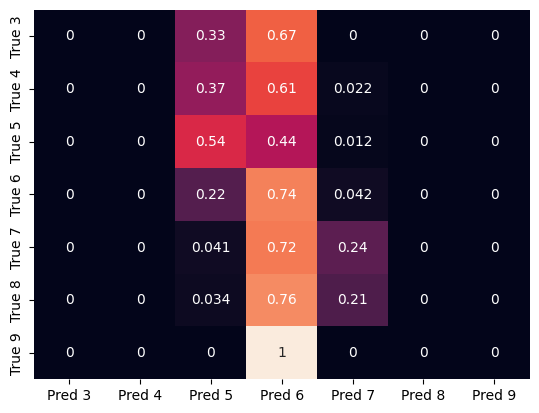

In [12]:
import numpy as np

# Normalise confusion matrix
results_norm = results.astype('float') / results.sum(axis=1)[:, np.newaxis]

# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results_norm, ['True 3', 'True 4', 'True 5', 'True 6', 'True 7', 'True 8', 'True 9'],
                     ['Pred 3', 'Pred 4', 'Pred 5', 'Pred 6', 'Pred 7', 'Pred 8', 'Pred 9'])
cm = sns.heatmap(df_cm, annot=True, cbar=False)
fig = cm.get_figure()

In [13]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'wine_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
wine_model = mr.python.create_model(
    name="wine_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="wine quality Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/26140 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/850086 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/1048 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/196758/models/wine_model/1


Model(name: 'wine_model', version: 1)